In [1]:
#%matplotlib notebook
import os, time, sys
import importlib
import tables as tb
import matplotlib.pyplot as plt
import numpy as np
import yaml

import panda2.panda2 as panda2
import panda2.analysis.fitfunctions as fitfunc
import panda2.scans.injection_scan as injection_scan
import panda2.analysis.interpreter as interpreter
import panda2.analysis.event_builder as event_builder

datdir = '/home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/finding_TDACparameters'


def get_pix_tdac(fraw, npix=1): 
    with tb.open_file(fraw) as f:
        comp1 = np.array(yaml.safe_load(f.root.meta_data.get_attr('en_comp1_before')))
        tdac = np.array(yaml.safe_load(f.root.meta_data.get_attr('tdac1_before')))
        arg = np.argwhere(comp1==1)
        if len(arg)!=npix:
            print('ERROR!!!!!', fraw)
        if npix==1: ###TODO only for 1pix
            return arg[0,0], arg[0,1], tdac[arg[0,0], arg[0,1]]
        else:
            return arg
        
        
        
def get_conf(fraw, conf_name='IPDAC'):
    with tb.open_file(fraw) as f:
        conf = yaml.unsafe_load(f.root.meta_data.get_attr('firmware_before'))
        if conf_name in ['VDACBL']:
            return int(conf['CONF'][conf_name], 2)
        else:
            return int(conf['CONF'][conf_name][::-1], 2)

def plot_data(list_fraw):
    ret = np.empty(len(list_fraw), 
                   dtype = [('fname', 'S128'),('th','f'),
                            ('th_err','f'),('col','i'),
                            ('row','i'), ('IPDAC', 'i'), ('tdac','i')])
    for i, fraw in enumerate(list_fraw):
        fname = os.path.basename(fraw)
        fhit = fraw[:-7] + 'hit.h5'
        ## get data from hit file (event_data)
        with tb.open_file(fhit) as f:
            dat = f.root.event_data[:]
        ## get data from raw data (scan_parameters)
        with tb.open_file(fraw) as f:
            param = f.root.scan_parameters[:]
        col, row, tdac= get_pix_tdac(fraw)
        ## select hits from comparator1
        dat1 = dat[dat['comp']==1] #### slow
        #dat1 = dat[dat['comp']==0] #### fast   ##hui
        if len(dat1)!=0:
        #print(dat1)
            uni, idx = np.unique(dat1['timestamp'], return_index=True)
            dat1 = dat1[idx]
            nhit1 = np.bincount(dat1['event_number']) #, minlength=len(param))
            try:
                fit = fitfunc.fit_scurve(param['inj'], nhit1, reverse=False)
                x = np.linspace(np.min(param['inj']), np.max(param['inj']), num=100)
                plt.plot(x, fitfunc.scurve(x,*fit[:3]), 'C{}-'.format(i%10))
            except:
                print(os.path.basename(fraw), nhit1)
            label ='[{0:d},{1:d}] {2:s} {3:.3f}'.format(col, row, fname.split('_')[1], fit[1])
            plt.plot(param['inj'], nhit1, 'C{}.'.format(i%10), label=label)
        
            ret[i]['fname']=fraw 
            ret[i]['th']=fit[1]
            ret[i]['th_err']=fit[1+3]
            ret[i]['col']=col
            ret[i]['row']=row
            ret[i]['tdac']=tdac
            ret[i]['IPDAC']=get_conf(fraw, 'IPDAC')


    ## show x-axis and y-axis and legend
    plt.xlim(0,0.2)
    plt.xlabel('Injection[V]')
    plt.ylabel('#')
    plt.legend()
    return ret

def plot_data_png(list_fraw):
    ret = np.empty(len(list_fraw), 
                   dtype = [('fname', 'S128'),('th','f'),
                            ('th_err','f'),('col','i'),
                            ('row','i'), ('tdac', 'i')
                            #('IPDAC', 'i')
                           ])
    ## prepare for plot
    fig,ax = plt.subplots()
    outdir = os.path.join(os.path.dirname(list_fraw[0]),"img")
    isExist = os.path.exists(outdir)
    if not isExist:
       os.makedirs(outdir)

    for i, fraw in enumerate(list_fraw):
        fname = os.path.basename(fraw)
        fhit = fraw[:-7] + 'hit.h5'
        ## get data from hit file (event_data)
        with tb.open_file(fhit) as f:
            dat = f.root.event_data[:]
        ## get data from raw data (scan_parameters)
        with tb.open_file(fraw) as f:
            param = f.root.scan_parameters[:]
        col, row, tdac = get_pix_tdac(fraw)
        ## select hits from comparator1
        dat1 = dat[dat['comp']==1] #### slow
        #dat1 = dat[dat['comp']==0] #### fast   ##hui
        if len(dat1)!=0:
            uni, idx = np.unique(dat1['timestamp'], return_index=True)
            dat1 = dat1[idx]
            nhit1 = np.bincount(dat1['event_number'], minlength=len(param))
            
            fit = fitfunc.fit_scurve(param['inj'], nhit1, reverse=False)
            x = np.linspace(np.min(param['inj']), np.max(param['inj']), num=100)
            label ='[{0:d},{1:d}] {2:s} {3:.3f}'.format(col, row, fname.split('_')[1], fit[1])
            ax.plot(x, fitfunc.scurve(x,*fit[:3]), 'C{}-'.format(i))
            ax.plot(param['inj'], nhit1, 'C{}.'.format(i), label=label)
            ret[i]['fname']=fraw 
            ret[i]['th']=fit[1]
            ret[i]['th_err']=fit[1+3]
            ret[i]['col']=col
            ret[i]['row']=row
            ret[i]['tdac']=tdac
            #ret[i]['IPDAC']=get_conf(fraw, 'IPDAC')

    ## saving plot
    ax.set_xlim(0,0.2)
    ax.set_xlabel('Injection[V]')
    ax.set_ylabel('#')
    ax.legend()
    ax.set_title('{}-{} tdac={}'.format(col,row,tdac))
    fig.savefig(os.path.join(outdir,'{}-{}_tdac{}.png'.format(col,row,tdac)))
    plt.close()
    return ret


In [2]:
## TDAC0 IPDAC16 VDACTh150 IBLRes1 IBL128 slow vssa1.2V
datdir = '/home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/9pixels/tdacscan_others7'
list_fraw = []
dtype = [('fname', 'S128'),('th','f'),
        ('th_err','f'),('col','i'),
        ('row','i'), ('tdac', 'i')
                            #('IPDAC', 'i')
        ]

analyze = True
t0 = time.time()
for fname in np.sort(os.listdir(datdir)):
    if fname[-7:] == 'scan.h5':
        fraw = os.path.join(datdir, fname)
        if analyze:
            fhit = fraw[:-7] + 'hit.h5'
            interpreter.interpret_h5(fraw, fhit)
            event_builder.build_h5(fraw=fraw, fhit=fhit)
        list_fraw.append(fraw)
    print(time.time()-t0)


ret=np.empty(len(list_fraw), dtype=dtype)    ##should change ret
for i, fraw in enumerate(list_fraw):
    ret[i] = plot_data_png([fraw])           ##should change ret
    if i%100==0:
        print('time for calculation ({0}/{1}) {2:.2f}s'.format(
                                             i, len(list_fraw),time.time()-t0
                                            )
             )
try:
   os.makedirs(os.path.join(datdir,'results'))
except:
    pass

retname = os.path.join(os.path.join(datdir,'results'), 'res.npy')
np.save(retname, ret)
tdacall = np.load(retname)  ### change variable name 

0.0010454654693603516


2024-05-17 20:55:37,832 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=18
2024-05-17 20:55:37,833 - root - [INFO    ] (MainThread) 0.11s hit=1259/1259 event=1241 ts=3800/3800
2024-05-17 20:55:37,840 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=14
2024-05-17 20:55:37,840 - root - [INFO    ] (MainThread) 0.00s hit=1090/1090 event=1076 ts=3800/3800
2024-05-17 20:55:37,847 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=9
2024-05-17 20:55:37,847 - root - [INFO    ] (MainThread) 0.00s hit=1373/1373 event=1364 ts=3800/3800
2024-05-17 20:55:37,854 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=22
2024-05-17 20:55:37,854 - root - [INFO    ] (MainThread) 0.00s hit=901/901 event=879 ts=3800/3800
2024-05-17 20:55:37,860 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=13
2024-05-17 20:55:37,860 - root - [INFO    ] (MainThread) 0.00s hit=1247/1247 event=1234 ts=3800/3800
2024-05-17 20:55:37,867 - root - [INFO    ] (Main

0.69s 17626/17626 hit=1259 ts=3800
0.814763069152832
0.8147742748260498
0.00s 16795/16795 hit=1090 ts=3800
0.8218696117401123
0.8218767642974854
0.00s 18231/18231 hit=1373 ts=3800
0.8293485641479492
0.8293581008911133
0.00s 15819/15819 hit=901 ts=3800
0.835942268371582
0.8359489440917969
0.00s 17588/17588 hit=1247 ts=3800
0.8423435688018799
0.842350959777832
0.00s 18069/18069 hit=1340 ts=3800
0.8494532108306885
0.849461555480957
0.03s 1665632/1665632 hit=1647672 ts=3800


2024-05-17 20:55:37,937 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=1646032
2024-05-17 20:55:37,937 - root - [INFO    ] (MainThread) 0.02s hit=1647672/1647672 event=1640 ts=3800/3800
2024-05-17 20:55:37,945 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=10
2024-05-17 20:55:37,945 - root - [INFO    ] (MainThread) 0.00s hit=1382/1382 event=1372 ts=3800/3800
2024-05-17 20:55:37,952 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=9
2024-05-17 20:55:37,952 - root - [INFO    ] (MainThread) 0.00s hit=1525/1525 event=1516 ts=3800/3800
2024-05-17 20:55:37,959 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=34
2024-05-17 20:55:37,959 - root - [INFO    ] (MainThread) 0.00s hit=1428/1428 event=1394 ts=3800/3800
2024-05-17 20:55:37,966 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=8
2024-05-17 20:55:37,966 - root - [INFO    ] (MainThread) 0.00s hit=1248/1248 event=1240 ts=3800/3800
2024-05-17 20:55:37,973 - root - [IN

0.9195241928100586
0.9195404052734375
0.00s 18272/18272 hit=1382 ts=3800
0.927316427230835
0.9273252487182617
0.00s 18990/18990 hit=1525 ts=3800
0.9343936443328857
0.9344017505645752
0.00s 18408/18408 hit=1428 ts=3800
0.9412782192230225
0.9412858486175537
0.00s 17612/17612 hit=1248 ts=3800
0.9479024410247803
0.9479098320007324
0.00s 18818/18818 hit=1492 ts=3800
0.9548215866088867
0.9548301696777344
0.00s 15975/15975 hit=1162 ts=3800
0.9616403579711914
0.96164870262146
0.00s 18436/18436 hit=1411 ts=3800
0.9683187007904053
0.9683284759521484
0.00s 18848/18848 hit=1672 ts=3800
0.9750266075134277
0.9750337600708008
0.00s 19541/19541 hit=1636 ts=3800
0.9818997383117676
0.9819083213806152
0.00s 18777/18777 hit=1483 ts=3800
0.9882907867431641
0.988297700881958
0.00s 19452/19452 hit=1622 ts=3800
0.995250940322876
0.9952592849731445
0.00s 17599/17599 hit=1249 ts=3800
1.002000093460083
1.0020077228546143
0.00s 18385/18385 hit=1409 ts=3800
1.008749008178711
1.008756399154663
0.00s 19302/19302 hit

2024-05-17 20:55:38,143 - root - [INFO    ] (MainThread) 0.03s hit=3320409/3320409 event=1540 ts=3800/3800
2024-05-17 20:55:38,150 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=11
2024-05-17 20:55:38,150 - root - [INFO    ] (MainThread) 0.00s hit=1632/1632 event=1621 ts=3800/3800
2024-05-17 20:55:38,156 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=11
2024-05-17 20:55:38,157 - root - [INFO    ] (MainThread) 0.00s hit=1601/1601 event=1590 ts=3800/3800
2024-05-17 20:55:38,163 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=9
2024-05-17 20:55:38,164 - root - [INFO    ] (MainThread) 0.00s hit=1686/1686 event=1677 ts=3800/3800
2024-05-17 20:55:38,170 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=115
2024-05-17 20:55:38,170 - root - [INFO    ] (MainThread) 0.00s hit=1360/1360 event=1245 ts=3800/3800
2024-05-17 20:55:38,176 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=14
2024-05-17 20:55:38,176 - root - [INFO 

1.1250512599945068
1.1250662803649902
0.00s 19519/19519 hit=1632 ts=3800
1.132199764251709
1.132206678390503
0.00s 19362/19362 hit=1601 ts=3800
1.1387171745300293
1.1387255191802979
0.00s 19794/19794 hit=1686 ts=3800
1.145374059677124
1.145381212234497
0.00s 17742/17742 hit=1360 ts=3800
1.1517550945281982
1.1517620086669922
0.00s 18944/18944 hit=1519 ts=3800
1.1579573154449463
1.1579639911651611
0.00s 19846/19846 hit=1708 ts=3800
1.1646900177001953
1.1646974086761475
0.04s 2229128/2229128 hit=2214312 ts=3800
1.2282524108886719
1.228261947631836
0.00s 19693/19693 hit=1675 ts=3800
1.2352511882781982
1.2352585792541504
0.00s 19554/19554 hit=1636 ts=3800
1.2419335842132568
1.241941213607788
0.00s 19592/19592 hit=1643 ts=3800
1.2486917972564697
1.24869966506958
0.00s 19829/19829 hit=1692 ts=3800
1.2552440166473389
1.2552518844604492
0.00s 20236/20236 hit=1780 ts=3800
1.2618324756622314
1.2618396282196045
0.00s 17626/17626 hit=1252 ts=3800
1.268568515777588
1.2685761451721191
0.00s 19484/194

2024-05-17 20:55:38,365 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=1578381
2024-05-17 20:55:38,365 - root - [INFO    ] (MainThread) 0.01s hit=1580063/1580063 event=1682 ts=3800/3800
2024-05-17 20:55:38,373 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=17
2024-05-17 20:55:38,373 - root - [INFO    ] (MainThread) 0.00s hit=1633/1633 event=1616 ts=3800/3800
2024-05-17 20:55:38,380 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=15
2024-05-17 20:55:38,380 - root - [INFO    ] (MainThread) 0.00s hit=1773/1773 event=1758 ts=3800/3800
2024-05-17 20:55:38,386 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=11
2024-05-17 20:55:38,387 - root - [INFO    ] (MainThread) 0.00s hit=1833/1833 event=1822 ts=3800/3800
2024-05-17 20:55:38,441 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=1907261
2024-05-17 20:55:38,442 - root - [INFO    ] (MainThread) 0.02s hit=1908498/1908498 event=1237 ts=3800/3800
2024-05-17 20:55:38,449

0.03s 1598192/1598192 hit=1580063 ts=3800
1.3474454879760742
1.3474557399749756
0.00s 19500/19500 hit=1633 ts=3800
1.354865550994873
1.3548738956451416
0.00s 20207/20207 hit=1773 ts=3800
1.361677646636963
1.3616855144500732
0.00s 20524/20524 hit=1833 ts=3800
1.3686587810516357
1.3686671257019043
0.03s 1924846/1924846 hit=1908498 ts=3800
1.4244537353515625
0.00s 20295/20295 hit=1986 ts=3800
1.4317243099212646
0.00s 20570/20570 hit=1841 ts=3800
1.4386341571807861
0.00s 15731/15731 hit=874 ts=3800
1.4453117847442627
0.00s 20627/20627 hit=1855 ts=3800
1.452218770980835
0.00s 20287/20287 hit=1791 ts=3800
1.459061861038208
0.00s 19542/19542 hit=1638 ts=3800
1.4658596515655518
0.00s 20658/20658 hit=1861 ts=3800
1.4732770919799805
0.00s 20934/20934 hit=1916 ts=3800
1.4801604747772217
0.00s 17684/17684 hit=1270 ts=3800
1.4870567321777344
0.00s 20537/20537 hit=1842 ts=3800
1.493622064590454
0.00s 21093/21093 hit=1945 ts=3800
1.5004618167877197
0.00s 15873/15873 hit=906 ts=3800
1.5070233345031738

2024-05-17 20:55:38,551 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=12
2024-05-17 20:55:38,552 - root - [INFO    ] (MainThread) 0.00s hit=1966/1966 event=1954 ts=3800/3800
2024-05-17 20:55:38,558 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=11
2024-05-17 20:55:38,559 - root - [INFO    ] (MainThread) 0.00s hit=1970/1970 event=1959 ts=3800/3800
2024-05-17 20:55:38,652 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=3761697
2024-05-17 20:55:38,652 - root - [INFO    ] (MainThread) 0.03s hit=3762951/3762951 event=1254 ts=3800/3800
2024-05-17 20:55:38,660 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=8
2024-05-17 20:55:38,660 - root - [INFO    ] (MainThread) 0.00s hit=1923/1923 event=1915 ts=3800/3800
2024-05-17 20:55:38,666 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=12
2024-05-17 20:55:38,666 - root - [INFO    ] (MainThread) 0.00s hit=2022/2022 event=2010 ts=3800/3800
2024-05-17 20:55:38,673 - root - [I

1.5336415767669678
0.00s 21207/21207 hit=1970 ts=3800
1.5404374599456787
0.06s 3779368/3779368 hit=3762951 ts=3800
1.634939193725586
0.00s 20990/20990 hit=1923 ts=3800
1.6417953968048096
0.00s 21463/21463 hit=2022 ts=3800
1.648282766342163
0.00s 15799/15799 hit=892 ts=3800
1.6549382209777832
0.00s 21802/21802 hit=2090 ts=3800
1.6614577770233154
0.00s 21153/21153 hit=1957 ts=3800
1.6681647300720215
0.00s 19559/19559 hit=1641 ts=3800
1.6754677295684814
0.00s 21660/21660 hit=2063 ts=3800
1.6822361946105957
0.00s 21632/21632 hit=2057 ts=3800
1.688905954360962
0.00s 17392/17392 hit=1263 ts=3700
1.6955592632293701
0.00s 16437/16437 hit=1078 ts=3700
1.702026128768921
0.00s 17946/17946 hit=1374 ts=3700
1.7086102962493896
0.00s 15520/15520 hit=890 ts=3700
1.7152936458587646
0.00s 17262/17262 hit=1240 ts=3700
1.721851110458374
0.00s 17731/17731 hit=1334 ts=3700
1.7283062934875488
0.00s 19257/19257 hit=1643 ts=3700


2024-05-17 20:55:38,753 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=15
2024-05-17 20:55:38,753 - root - [INFO    ] (MainThread) 0.00s hit=1643/1643 event=1628 ts=3700/3700
2024-05-17 20:55:38,759 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=4
2024-05-17 20:55:38,760 - root - [INFO    ] (MainThread) 0.00s hit=1380/1380 event=1376 ts=3700/3700
2024-05-17 20:55:38,766 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=10
2024-05-17 20:55:38,766 - root - [INFO    ] (MainThread) 0.00s hit=1518/1518 event=1508 ts=3700/3700
2024-05-17 20:55:38,773 - root - [INFO    ] (MainThread) 0.00s hit=1389/1389 event=1389 ts=3700/3700
2024-05-17 20:55:38,779 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=2
2024-05-17 20:55:38,779 - root - [INFO    ] (MainThread) 0.00s hit=1236/1236 event=1234 ts=3700/3700
2024-05-17 20:55:38,785 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=8
2024-05-17 20:55:38,786 - root - [INFO    ] (Mai

1.7349543571472168
0.00s 17985/17985 hit=1380 ts=3700
1.7414641380310059
0.00s 18652/18652 hit=1518 ts=3700
1.748258113861084
0.00s 18045/18045 hit=1389 ts=3700
1.7546541690826416
0.00s 17272/17272 hit=1236 ts=3700
1.761054515838623
0.00s 18438/18438 hit=1474 ts=3700
1.7675704956054688
0.00s 15491/15491 hit=879 ts=3700
1.774014949798584
0.00s 18062/18062 hit=1393 ts=3700
1.7803459167480469
0.00s 18341/18341 hit=1449 ts=3700
1.7869067192077637
0.00s 19233/19233 hit=1629 ts=3700
1.7933871746063232
0.00s 18491/18491 hit=1489 ts=3700
1.7998948097229004
0.00s 19239/19239 hit=1630 ts=3700
1.8064942359924316
0.00s 17339/17339 hit=1250 ts=3700
1.8131463527679443
0.00s 18038/18038 hit=1390 ts=3700
1.8194189071655273
0.00s 19003/19003 hit=1582 ts=3700
1.8262231349945068
0.00s 15492/15492 hit=884 ts=3700
1.8328444957733154
0.00s 18691/18691 hit=1523 ts=3700
1.8396093845367432
0.00s 18874/18874 hit=1560 ts=3700
1.8462605476379395
0.00s 19253/19253 hit=1632 ts=3700
1.8531887531280518
0.00s 19073/19

2024-05-17 20:55:38,955 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=12
2024-05-17 20:55:38,955 - root - [INFO    ] (MainThread) 0.00s hit=1615/1615 event=1603 ts=3700/3700
2024-05-17 20:55:38,961 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=8
2024-05-17 20:55:38,962 - root - [INFO    ] (MainThread) 0.00s hit=1758/1758 event=1750 ts=3700/3700
2024-05-17 20:55:38,968 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=8
2024-05-17 20:55:38,968 - root - [INFO    ] (MainThread) 0.00s hit=875/875 event=867 ts=3700/3700
2024-05-17 20:55:38,974 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=2
2024-05-17 20:55:38,974 - root - [INFO    ] (MainThread) 0.00s hit=1723/1723 event=1721 ts=3700/3700
2024-05-17 20:55:38,980 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=9
2024-05-17 20:55:38,981 - root - [INFO    ] (MainThread) 0.00s hit=1692/1692 event=1683 ts=3700/3700
2024-05-17 20:55:38,987 - root - [INFO    ] (MainThr

1.9370086193084717
0.00s 19860/19860 hit=1758 ts=3700
1.9435620307922363
0.00s 15445/15445 hit=875 ts=3700
1.94987154006958
0.00s 19708/19708 hit=1723 ts=3700
1.9562504291534424
0.00s 19525/19525 hit=1692 ts=3700
1.9626011848449707
0.00s 19214/19214 hit=1626 ts=3700
1.9695584774017334
0.00s 19927/19927 hit=1767 ts=3700
1.9762122631072998
0.00s 20169/20169 hit=1816 ts=3700
1.982755422592163
0.00s 17347/17347 hit=1251 ts=3700
1.9892168045043945
0.00s 19672/19672 hit=1716 ts=3700
1.9956023693084717
0.00s 20247/20247 hit=1834 ts=3700
2.0019946098327637
0.00s 15469/15469 hit=880 ts=3700
2.008370876312256
0.00s 20333/20333 hit=1852 ts=3700
2.014589548110962
0.00s 19974/19974 hit=1781 ts=3700
2.021207809448242
0.00s 19228/19228 hit=1627 ts=3700
2.0275111198425293
0.00s 20280/20280 hit=1840 ts=3700
2.0339064598083496
0.00s 20678/20678 hit=1918 ts=3700
2.0403189659118652
0.00s 17348/17348 hit=1251 ts=3700
2.047100782394409
0.00s 20251/20251 hit=1831 ts=3700
2.053386688232422
0.00s 20766/20766 h

2024-05-17 20:55:39,160 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=2
2024-05-17 20:55:39,161 - root - [INFO    ] (MainThread) 0.00s hit=1629/1629 event=1627 ts=3700/3700
2024-05-17 20:55:39,167 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=2
2024-05-17 20:55:39,167 - root - [INFO    ] (MainThread) 0.00s hit=2051/2051 event=2049 ts=3700/3700
2024-05-17 20:55:39,173 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=1
2024-05-17 20:55:39,173 - root - [INFO    ] (MainThread) 0.00s hit=2060/2060 event=2059 ts=3700/3700


0.00s 19237/19237 hit=1629 ts=3700
2.1424570083618164
0.00s 21347/21347 hit=2051 ts=3700
2.148730993270874
0.00s 21396/21396 hit=2060 ts=3700
2.155146360397339
2.155153512954712
2.1551554203033447
time for calculation (0/144) 2.27s
time for calculation (100/144) 9.42s


In [83]:
for i in range(8):
    tmp = retall['th'][retall['tdac']==i]
    plt.hist(tmp, label='tdac{}'.format(i),histtype='step')
plt.legend()

Text(0, 0.5, 'Threshold[Vinj]')

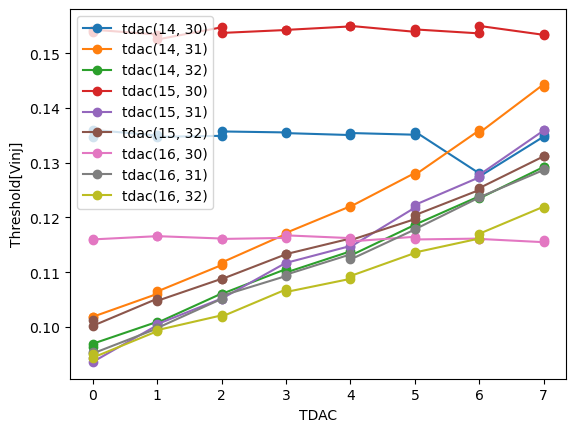

In [4]:

sortret = tdacall[np.argsort(tdacall[['col','row','tdac']])]

#print(sortret[['col','row','tdac','th']])

uni, idx, cnt = np.unique(sortret[['col', 'row']], return_index=True, return_counts=True)

for u_i, u in enumerate(uni) :
    tmp = sortret[idx[u_i]:idx[u_i]+cnt[u_i]]
    #print(tmp[['col','row','tdac','th']])
    plt.plot(tmp['tdac'],tmp['th'], 'o-',label='tdac{}'.format(u))

plt.legend()
plt.xlabel('TDAC')
plt.ylabel('Threshold[Vinj]')

In [80]:
############
## IPDAC 16 tuned TDAC
datdir = '/home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/9pixels/tuned_tdac'
list_fraw = []
for fname in (np.sort(os.listdir(datdir))):
    if fname[-7:] == 'scan.h5':
        if fname in ['20240517_123825_injection_scan.h5']:
            continue
        print(fname)
        list_fraw.append(os.path.join(datdir, fname))
ret16_7 = plot_data(list_fraw)

20240517_144908_injection_scan.h5
20240517_144932_injection_scan.h5
20240517_144939_injection_scan.h5
20240517_144946_injection_scan.h5
20240517_144953_injection_scan.h5
20240517_145000_injection_scan.h5
20240517_145007_injection_scan.h5
20240517_145014_injection_scan.h5
20240517_145021_injection_scan.h5


##  Matrix

In [ ]:
## TDAC0 IPDAC16 VDACTh150 IBLRes1 IBL128 slow vssa1.2V   Matrix!!!
datdir = '/home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/matrix/slow_tdac0'
list_fraw = []
dtype = [('fname', 'S128'),('th','f'),
        ('th_err','f'),('col','i'),
        ('row','i'), 
                            #('IPDAC', 'i')
        ]
for fname in np.sort(os.listdir(datdir)):
    if fname[-7:] == 'scan.h5':
        #print(fname)
        list_fraw.append(os.path.join(datdir, fname))
t0 = time.time()
ret0=np.empty(len(list_fraw), dtype=dtype)    ##should change ret
for i, fraw in enumerate(list_fraw):
    ret0[i] = plot_data_png([fraw])           ##should change ret
    if i%100==0:
        print('time for calculation ({0}/{1}) {2:.2f}s'.format(
                                             i, len(list_fraw),time.time()-t0
                                            )
             )

In [ ]:
datdir = '/home/hzhang/workspace/tmp/panda2-daq/kit-gitlab/output/matrix/slow_tdac0'
os.makedirs(os.path.join(datdir,'results'))
np.save(os.path.join(os.path.join(datdir,'results'), 'th_tdac0.npy'), ret0)

In [ ]:
bins = np.arange(0.02,0.14,0.001)
x = (bins[:-1]+bins[1:])/2.0

#####
tmp = ret[ret['row']>0]
hist = plt.hist(tmp['th'], bins=bins,
               histtype="step", color='C0');
fit = fitfunc.fit_gauss(x, hist[0])
plt.plot(x, fitfunc.gauss(x, *fit[:3]),
        label="th={0:.3f}, sigma={1:.3f}".format(fit[1], fit[2]),
        color='C0')
####
tmp = ret0[ret0['row']>0]

hist = plt.hist(tmp['th'], bins=bins,
               histtype="step", color='C1')
fit = fitfunc.fit_gauss(x, hist[0])
plt.plot(x, fitfunc.gauss(x, *fit[:3]),
        label="tdac={0:.0f}, th={0:.3f}, sigma={1:.3f}".format(fit[1], fit[2]),
        color='C1')



####
tmp = ret1[ret1['row']>0]

hist = plt.hist(tmp['th'], bins=bins,
               histtype="step", color='C2')
fit = fitfunc.fit_gauss(x, hist[0])
plt.plot(x, fitfunc.gauss(x, *fit[:3]),
        label="th={0:.3f}, sigma={1:.3f}".format(fit[1], fit[2]),
        color='C2')


plt.legend()

In [ ]:
tmp[['col','row','th']][tmp['th']>0.09]

In [ ]:
img =np.

In [ ]:
Z = np.random.rand(6, 10)
len(Z)

In [ ]:
## get data from hit file (event_data)
#fname = os.path.basename(fraw)
fraw = os.path.join(datdir,'20240315_123118_injection_scan.h5')
fhit = fraw[:-7] + 'hit.h5'

with tb.open_file(fhit) as f:
    dat = f.root.event_data[:]
## get data from raw data (scan_parameters)
with tb.open_file(fraw) as f:
    param = f.root.scan_parameters[:]

## select hits from comparator1
dat1 = dat[dat['comp']==1]
nhit1 = np.bincount(dat1['event_number']) #, minlength=len(param))

fig, ax = plt.subplots(ncols=1, nrows=2, sharex=True)
ax[0].plot(param['inj'], nhit1, '.-')

xbins = np.arange(param['inj'][0]-(param['inj'][-1]-param['inj'][-2])/2, 
                  param['inj'][-1]+(param['inj'][-1]+param['inj'][-2])/2,
                  param['inj'][-1]-param['inj'][-2])
                  

ax[1].hist2d(param[dat1['event_number']]['inj'], dat1['tot'], 
           bins=[xbins, np.arange(1, 2048,10)]);
ax[0].set_xlim(0,0.7)

In [ ]:
fraw = os.path.join(datdir,'20240315_123507_injection_scan.h5')
fhit = fraw[:-7] + 'hit.h5'

with tb.open_file(fhit) as f:
    dat = f.root.event_data[:]
## get data from raw data (scan_parameters)
with tb.open_file(fraw) as f:
    param = f.root.scan_parameters[:]

## select hits from comparator1
dat1 = dat[dat['comp']==1]
nhit1 = np.bincount(dat1['event_number']) #, minlength=len(param))

fig, ax = plt.subplots(ncols=1, nrows=2, sharex=True)
ax[0].plot(param['inj'], nhit1, '.-')

xbins = np.arange(param['inj'][0]-(param['inj'][-1]-param['inj'][-2])/2, 
                  param['inj'][-1]+(param['inj'][-1]+param['inj'][-2])/2,
                  param['inj'][-1]-param['inj'][-2])
                  

ax[1].hist2d(param[dat1['event_number']]['inj'], dat1['tot'], 
           bins=[xbins, np.arange(1, 2048,10)]);
ax[0].set_xlim(0,0.7)

In [ ]:
list_fraw = []
list_fraw.append(os.path.join(datdir, '20240314_104621_injection_scan.h5'))  # TDAC= 7 IPDAC=8 VComp2=10
list_fraw.append(os.path.join(datdir, '20240314_104641_injection_scan.h5'))  # TDAC= 0 IPDAC=8 VComp2=10
list_fraw.append(os.path.join(datdir, '20240314_104748_injection_scan.h5'))  # TDAC= 3 IPDAC=12 VComp2=16

#list_fraw.append(os.path.join(datdir, '20240308_125247_injection_scan.h5'))  # TDAC=7 IPDAC=12 VComp2=32
#list_fraw.append(os.path.join(datdir, '20240308_123703_injection_scan.h5'))  # TDAC=7 IPDAC=4
#list_fraw.append(os.path.join(datdir, '20240308_124602_injection_scan.h5'))  # TDAC=3 IPDAC=4

plot_data(list_fraw)